In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import KNNBasic, Dataset, Reader
#from surprise.model_selection import KFold
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from collections import defaultdict
import itertools

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from helper_functions import create_user_item_matrix, get_movie_id_from_title, get_top_ten_similar_movies

# User-based filtering collaborative filtering

We find other users similar to the user we’re recommending movies to. Then we recommend the movies those other users rated highly.
<br>
Two users will be declared similar if they gave a high (or low) rating to the same movies.

User A loves Fight Club and The Shawshank Redemption and dislikes Love Actually.
<br>
User B loves Fight Club, The Shawshank Redemption, and Taken, and dislikes Love Actually.
<br>
The presumption in this methodology is that Taken would be a good recommendation for User A because User A is similar to User B.

# Surprise library
The sklearn.metrics.pairwise.cosine_similarity does not handle NaN values (missing ratings) so I wrote the code myself but upon looking into the Surprise library I was 'surprised' (forgive me) to discover that it actually can handle NaN values.

- It should be optimised to be much faster than the code in the cosine_similarity notebook.
- It also uses the K Nearest Neighbours algorithm so we can forget about all the percentile/mean+std thresholds, I was previously applying in the Pearson correlation calculation.
- We can apply overlap thresholds and use cross validation to optimise the results.

**For an explanation of the Cosine similarity, see the cosine_similarity notebook in the item_based_recommenders dir.**

Let's give it a go.

# Data import

In [2]:
movies_df = pd.read_csv('../data/ml-latest-small/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings_df = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Data analysis for feature parameter optimization

We need to analyze the sparsity and structure of our data to assess the correct ranges to use when optimizing our model parameters.

**min_support**
<br>
The minimum number of overlapping ratings required between two items for their similarity to be computed.

It ensures that two items must have been rated by at least min_support common users before their similarity is calculated. 
<br>
If the overlap is below the min_support threshold then the similarity score for the item-item pair is set to zero. 
<br>
This avoids statistically unreliable similarity scores from small sample sizes.

Sparse datasets: Choose a low value to ensure enough comparisons are made.

Dense datasets: Choose a higher valueto improve the reliability of the similarity scores.

**k**
<br>
In the KNNBasic (k-Nearest Neighbours) algorithm we will be using, k refers to the number of nearest neighbours to consider when making predictions.
<br>
We want k to be as large as possible  but if its too large then the algorithm may fail because if cannot find enough neighbours, or it may give bad predictions because it is using weakly similar neighbours.

Example: k=30 
<br>
- We calculate the similarity scores for all movies
- The algorithm selects the 30 most similar movies to the target movie
- The ratings for those movies (weighted by similarity) are used to predict the rating for a user who hasn't rated the target movie yet.

Large k value: 
<br>
- More general. Can risk underfitting. (Low variance, non-specific ratings)
- Good for large, dense datasets because there are plenty of neighbours to choose from.
- Doesn't work for highly sparse datasets because there aren't enough neighbours available for all movies.

Small k value:
<br>
- Good when the data is sparse.
- Uses only the most similar neighbours
- Captures more specific recommendations but can lead to overfitting (High variance).
- Good for small datasets because there are few neighbours available.

### Sparsity

Sparsity: 98.30%

Ratings per movie: 
count    9716.000000
mean       10.377007
std        22.408802
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       329.000000
dtype: float64



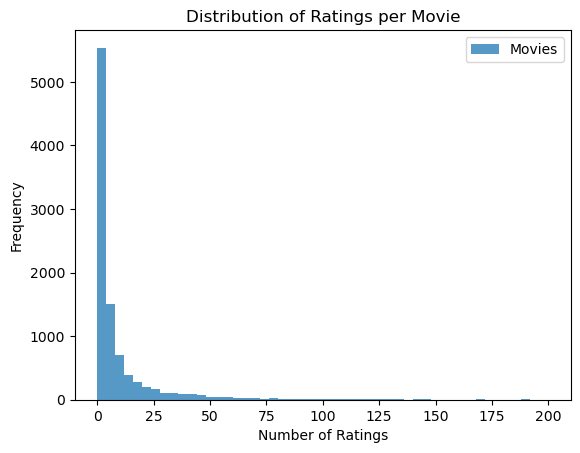

In [7]:
user_item_matrix = create_user_item_matrix(ratings_df)

# Calculate sparsity
total_possible_ratings = user_item_matrix.size  # Total cells in the matrix
actual_ratings = user_item_matrix.count().sum()  # Non-NaN ratings
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity: {sparsity:.2%}\n")

# Count of ratings per movie
ratings_per_movie = user_item_matrix.count(axis=0)
print(f"Ratings per movie: \n{ratings_per_movie.describe()}\n")

# Number of ratings per movie
ratings_per_movie = ratings_df['movieId'].value_counts()

# Plot distribution of ratings
plt.hist(ratings_per_movie, bins=50, range=(0, 200), alpha=0.75, label='Movies')
plt.legend()
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings per Movie')
plt.show()

The dataset is very sparse.

Many of the movies only have a single rating. There is a clear tendency for the popular movies to have more ratings. We can expect low overlap.

### Overlap

In [8]:
# Count the number of overlapping ratings for each pair of movies
# by taking the dot product of the boolean matrix (True=Rated, False=Not Rated)
# to get the number of common users for each movie
# Ensure boolean values are cast to integers before the dot product
overlap_counts = user_item_matrix.T.notnull().astype(int).dot(user_item_matrix.notnull().astype(int))

Median Overlap: 1.0
25th Percentile: 1.0
75th Percentile: 2.0
Max Overlap: 329


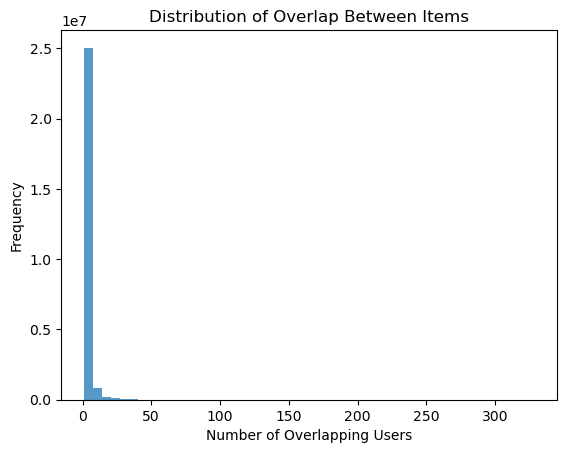

In [9]:
# Flatten the matrix to a 1D array and exclude diagonal (self-overlap)
overlap_values = overlap_counts.values.flatten()
overlap_values = overlap_values[overlap_values > 0]  # Exclude zeros

# Calculate overlap statistics
median_overlap = np.median(overlap_values)
print(f"Median Overlap: {median_overlap}")
percentile_25 = np.percentile(overlap_values, 25)
print(f"25th Percentile: {percentile_25}")
percentile_75 = np.percentile(overlap_values, 75)
print(f"75th Percentile: {percentile_75}")
max_overlap = np.max(overlap_values)
print(f"Max Overlap: {max_overlap}")

plt.hist(overlap_values, bins=50, alpha=0.75)
plt.xlabel('Number of Overlapping Users')
plt.ylabel('Frequency')
plt.title('Distribution of Overlap Between Items')
plt.show()

In [10]:
def analyze_overlap(overlap_counts, min_support_values, k_values):
    for min_support in min_support_values:
        print(f"Analyzing for min_support = {min_support}\n")

        # Neighbours need to be above the overlap threshold to be counted
        # Here we count the number of neighbours each item will have.
        neighbors_per_item = (overlap_counts >= min_support).sum(axis=1)
        
        print(f"{neighbors_per_item.describe()}\n")
        
        for k in k_values:
            if k > neighbors_per_item.median():
                print(f"  k={k} may be too high.")
            else:
                print(f"  k={k} is reasonable.")
        print('\n\n')
min_support_values = [1, 2, 3, 4, 5]
k_values = [2, 5, 10, 15, 17, 20, 25, 30]
analyze_overlap(overlap_counts, min_support_values, k_values)

Analyzing for min_support = 1

count    9716.000000
mean     2707.940510
std      1994.490633
min        21.000000
25%      1027.000000
50%      2458.500000
75%      3982.000000
max      9316.000000
dtype: float64

  k=2 is reasonable.
  k=5 is reasonable.
  k=10 is reasonable.
  k=15 is reasonable.
  k=17 is reasonable.
  k=20 is reasonable.
  k=25 is reasonable.
  k=30 is reasonable.



Analyzing for min_support = 2

count    9716.000000
mean      975.946377
std      1270.954795
min         0.000000
25%         0.000000
50%       365.000000
75%      1607.000000
max      5961.000000
dtype: float64

  k=2 is reasonable.
  k=5 is reasonable.
  k=10 is reasonable.
  k=15 is reasonable.
  k=17 is reasonable.
  k=20 is reasonable.
  k=25 is reasonable.
  k=30 is reasonable.



Analyzing for min_support = 3

count    9716.000000
mean      555.048477
std       900.371168
min         0.000000
25%         0.000000
50%        16.000000
75%       791.250000
max      4647.000000
dtype: float64

 

### Parameter Grid

**We will use min_support=[1,2] and k=[5, 10, 15, 20] and fine-tune from there**

# Hyperparameter tuning

## Performance metrics

### Mean Absolute Error
To calculate MAE, we first find the difference between the actual rating and the estimated rating for each user and book pair. Then, we take the absolute value of these differences (which means we ignore negative signs) and find the average of all these absolute differences.

- Treats all errors equally, regardless of magnitude.
- Suitable if you want a more general measure of average prediction accuracy.

### Root Mean Square Error
To calculate RMSE, we find the difference between actual rating and estimated rating as we did with MAE but then we square these differences, find the average of all the squared differences and then take the square root of this average.

- Penalizes large errors more heavily than small ones due to the squaring of differences.
- Suitable if you care more about avoiding large prediction errors.

### Fraction of Concordant Pairs (FCP)
FCP measures how well the model preserves the relative order of item ratings for each user. It checks all pairs of items rated by a user and calculates the fraction where the predicted rating correctly reflects the user’s preference.

- Focuses on ranking quality rather than absolute rating accuracy.
- Suitable when the order of recommendations matters more than exact rating predictions.

### Mean Squared Error (MSE)
MSE calculates the average of the squared differences between actual ratings and predicted ratings. Like RMSE, it penalizes larger errors more heavily, but without taking the square root.

- Penalizes large errors more than small ones.
- Suitable for evaluating overall prediction accuracy, though less interpretable due to its squared units.

## Round 1 
### Grid search

In [5]:

# Load the data into a Surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Define parameter grid
param_grid = {
    'k': [5,  10, 15, 20],  # Number of neighbors used for predictions
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [True],  # Item-based filtering
        'min_support': [1, 2]  # Minimum overlap necessary to be considered similar
    }
}

# Perform grid search
grid_search = GridSearchCV(
    KNNBasic,  # k-Nearest Neighbours algorithm
    param_grid, 
    measures=['rmse', 'mae', 'mse', 'fcp'],  # Performance metrics
    cv=5  # num folds used for cross-validation
)
grid_search.fit(ratings_data)

print("Model parameter optimization completed.")

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


KeyboardInterrupt: 

In [12]:
# Print the performance metrics and their corresponding best parameters
print('\n')
print("Best Mean Absolute Error score:", grid_search.best_score['mae'])
print("Best parameters:", grid_search.best_params['mae'])

print('\n')
print("Best Root Meand Square Error score:", grid_search.best_score['rmse'])
print("Best parameters:", grid_search.best_params['rmse'])

print('\n')
print("Best Mean Squared Error score:", grid_search.best_score['mse'])
print("Best parameters:", grid_search.best_params['mse'])

print('\n')
print("Best Fraction of Concordant Pairs score:", grid_search.best_score['fcp'])
print("Best parameters:", grid_search.best_params['fcp'])



Best Mean Absolute Error score: 0.7469459300932686
Best parameters: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Best Root Meand Square Error score: 0.9731944929584213
Best parameters: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Best Mean Squared Error score: 0.9471171076432292
Best parameters: {'k': 20, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Best Fraction of Concordant Pairs score: 0.675715576488658
Best parameters: {'k': 20, 'sim_options': {'name': 'pearson', 'user_based': True, 'min_support': 1}}


### Helper functions

In [13]:
def get_top_N_similar_movies(movie_id, n, movies_df, algo):
    # Access the similarity matrix
    similarity_matrix = algo.sim
    
    # Get movie IDs
    movie_inner_id = algo.trainset.to_inner_iid(movie_id)  # Convert movieId to inner ID
    similar_items = similarity_matrix[movie_inner_id]
    
    # Find the top-N similar items
    similar_movies = sorted(list(enumerate(similar_items)), key=lambda x: x[1], reverse=True)
    
    # Map inner IDs back to raw movie IDs, filter out the target movie and return the top n
    top_n_similar_movies = [(algo.trainset.to_raw_iid(inner_id), similarity) for inner_id, similarity in similar_movies if algo.trainset.to_raw_iid(inner_id) != movie_id][:n]
    
    similar_movies_df = pd.DataFrame(top_n_similar_movies, columns=['movieId', movie_id])

    return similar_movies_df

def add_movie_titles_to_recommendations(similar_movies_df, movies_df, movie_id, movie_title):
    # Add the titles
    similar_movies_df = similar_movies_df.merge(movies_df[['movieId', 'title']], on='movieId', how='left')
    similar_movies_df.set_index('movieId', inplace=True)
    similar_movies_df = similar_movies_df.rename(columns={movie_id: movie_title +' - similarity'})

    return similar_movies_df

def create_model(params, ratings_data):
    # Initialize the optimized model
    model = KNNBasic(k=params['k'], sim_options=params['sim_options'])
    
    # Build the trainset and fit the model
    trainset = ratings_data.build_full_trainset()
    model.fit(trainset)

    return model
    

### Create model

(We do this in a separate cell so we don't have to retrain the model every time we want to check the recommendations for a movie)

In [14]:
# Use the best parameters from grid search
best_params = grid_search.best_params['fcp']
algo = create_model(best_params, ratings_data)

Computing the pearson similarity matrix...
Done computing similarity matrix.


### Recommend similar movies

In [23]:
'''unpopular movies'''
# movie_title = 'Halloween 4' 
# movie_title = 'Mortdecai'
# movie_title = 'Bo Burnham: Make Happy'
# movie_title = 'Wake Up, Ron Burgundy'

'''popular movies'''
movie_title = 'Godfather, The'
# movie_title = 'shawshank'
# movie_title = 'fight club'


'''  '''
n = 10
movie_id = get_movie_id_from_title(movie_title, movies_df)
similar_movies_df = get_top_N_similar_movies(movie_id, n, movies_df, algo)
top_ten = add_movie_titles_to_recommendations(similar_movies_df, movies_df, movie_id, movie_title)

print("Top Similar Movies:")
top_ten

IndexError: index 1026 is out of bounds for axis 0 with size 610

When I checked the recommendations manually with the best parameters for each performance metric, they were terrible for the both most popular and least popular movies. 

Let's keep trying.

## Round 2: Refine the parameter grid
### Grid search

In [24]:
# Define parameter grid
param_grid = {
    'k': [18, 19, 20, 21, 22, 25],  # Number of neighbors used for predictions
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [False],  # Item-based filtering
        'min_support': [1, 2, 3]  # Minimum overlap necessary to be considered similar
    }
}

# Perform grid search
grid_search_2 = GridSearchCV(
    KNNBasic,  # k-Nearest Neighbours algorithm
    param_grid, 
    measures=['rmse', 'mae', 'mse', 'fcp'],  # Performance metrics
    cv=5  # num folds used for cross-validation
)
grid_search_2.fit(ratings_data)

print("Model parameter optimization completed.")

# Print the performance metrics and their corresponding best parameters
print('\n')
print("Best Mean Absolute Error score:", grid_search_2.best_score['mae'])
print("Best parameters:", grid_search_2.best_params['mae'])

print('\n')
print("Best Root Meand Square Error score:", grid_search_2.best_score['rmse'])
print("Best parameters:", grid_search_2.best_params['rmse'])

print('\n')
print("Best Mean Squared Error score:", grid_search_2.best_score['mse'])
print("Best parameters:", grid_search_2.best_params['mse'])

print('\n')
print("Best Fraction of Concordant Pairs score:", grid_search_2.best_score['fcp'])
print("Best parameters:", grid_search_2.best_params['fcp'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

### Create model

(We do this in a separate cell so we don't have to retrain the model every time we want to check the recommendations for a movie)

In [26]:
# Try the best params for each performance metric
# performance_metric = 'rmse'
# performance_metric = 'mse'
# performance_metric = 'mae'
performance_metric = 'fcp'

best_params = grid_search_2.best_params[performance_metric]
algo_2 = create_model(best_params, ratings_data)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### Recommend similar movies

In [33]:
'''unpopular movies'''
# movie_title = 'Halloween 4'
# movie_title = 'Mortdecai'
# movie_title = 'Bo Burnham: Make Happy'
# movie_title = 'Wake Up, Ron Burgundy'

'''popular movies'''
# movie_title = 'Godfather, The'
# movie_title = 'shawshank'
movie_title = 'fight club'


'''  '''
n = 10
movie_id = get_movie_id_from_title(movie_title, movies_df)
similar_movies_df = get_top_N_similar_movies(movie_id, n, movies_df, algo_2)
top_ten = add_movie_titles_to_recommendations(similar_movies_df, movies_df, movie_id, movie_title)

print("Top Similar Movies:")
top_ten

Top Similar Movies:


,fight club - similarity,title
movieId,,
1279,1.000000,Night on Earth (1991)
8207,1.000000,"Day of the Jackal, The (1973)"
188301,1.000000,Ant-Man and the Wasp (2018)
2070,1.000000,Tender Mercies (1983)
2967,1.000000,"Bad Seed, The (1956)"
74916,1.000000,Greenberg (2010)
134170,0.999935,Kung Fury (2015)
1442,0.999920,Prefontaine (1997)
482,0.999920,Killing Zoe (1994)


Bad results again. The scores seem to be exactly the same as the previous round.

It looks like unpopular movies are being returned recommendations with similarity scores of 0.

This suggests the min_support is too high. 

Let's check.

## Round 3

In [6]:
# Load the data into a Surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)


# Define parameter grid
param_grid = {
    'k': [20, 25, 30, 35],  # Number of neighbors used for predictions
    'sim_options': {
        'name': ['cosine', 'pearson'],  # Similarity metrics
        'user_based': [False],  # Item-based filtering
        'min_support': [2, 3, 4]  # Minimum overlap necessary to be considered similar
    }
}

# Perform grid search
grid_search_3 = GridSearchCV(
    KNNBasic,  # k-Nearest Neighbours algorithm
    param_grid, 
    measures=['rmse', 'mae', 'mse', 'fcp'],  # Performance metrics
    cv=5  # num folds used for cross-validation
)
grid_search_3.fit(ratings_data)

print("Model parameter optimization completed.")

# Print the performance metrics and their corresponding best parameters
print('\n')
print("Best Mean Absolute Error score:", grid_search_3.best_score['mae'])
print("Best parameters:", grid_search_3.best_params['mae'])

print('\n')
print("Best Root Meand Square Error score:", grid_search_3.best_score['rmse'])
print("Best parameters:", grid_search_3.best_params['rmse'])

print('\n')
print("Best Mean Squared Error score:", grid_search_3.best_score['mse'])
print("Best parameters:", grid_search_3.best_params['mse'])

print('\n')
print("Best Fraction of Concordant Pairs score:", grid_search_3.best_score['fcp'])
print("Best parameters:", grid_search_3.best_params['fcp'])

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [ ]:
# Try the best params for each performance metric
# performance_metric = 'rmse'
# performance_metric = 'mse'
# performance_metric = 'mae'
performance_metric = 'fcp'

best_params = grid_search_3.best_params[performance_metric]
algo_3 = create_model(best_params, ratings_data)

In [ ]:
'''unpopular movies'''
# movie_title = 'Halloween 4'
# movie_title = 'Mortdecai'
# movie_title = 'Bo Burnham: Make Happy'
# movie_title = 'Wake Up, Ron Burgundy'

'''popular movies'''
# movie_title = 'Godfather, The'
# movie_title = 'shawshank'
movie_title = 'fight club'


'''  '''
n = 10
movie_id = get_movie_id_from_title(movie_title, movies_df)
similar_movies_df = get_top_N_similar_movies(movie_id, n, movies_df, algo_3)
top_ten = add_movie_titles_to_recommendations(similar_movies_df, movies_df, movie_id, movie_title)

print("Top Similar Movies:")
top_ten

## Manually chosen parameters

In the Overlap section above, we saw that for min_support=1, every movie had at least 21 neighbours, but for min_support=2, some movies had 0 neighbours.

The GridSearchCV method of tuning parameters is good for creating a model which can be generalized to (similar) data it hasn't seen before. That isn't really our use-case here. We have a small, sparse dataset and we want good recommendations. Its important to fit the approach to the use-case.

generalized

done


### Create model

(We do this in a separate cell so we don't have to retrain the model every time we want to check the recommendations for a movie)

In [79]:
params = {
    'k': 21,
    'sim_options': {
        'name': 'cosine',  
        'user_based': False,
        'min_support': 1
    }
}



algo_3 = create_model(params, ratings_data)


Computing the cosine similarity matrix...
Done computing similarity matrix.


### Recommend similar movies

In [86]:
'''unpopular movies'''
movie_title = 'Halloween 4' # bad results
# movie_title = 'Mortdecai' # bad results
# movie_title = 'Bo Burnham: Make Happy' # bad results
# movie_title = 'Wake Up, Ron Burgundy' # ok results

'''popular movies'''
# movie_title = 'Godfather, The' # bad results
# movie_title = 'shawshank' # bad results
# movie_title = 'fight club'


'''  '''
n = 10
movie_id = get_movie_id_from_title(movie_title, movies_df)
similar_movies_df = get_top_N_similar_movies(movie_id, n, movies_df, algo_3)
top_ten = add_movie_titles_to_recommendations(similar_movies_df, movies_df, movie_id, movie_title)

print("Top Similar Movies:")
top_ten

Top Similar Movies:


,Halloween 4 - similarity,title
movieId,,
1,1.0,Toy Story (1995)
3,1.0,Grumpier Old Men (1995)
50,1.0,"Usual Suspects, The (1995)"
110,1.0,Braveheart (1995)
216,1.0,Billy Madison (1995)
231,1.0,Dumb & Dumber (Dumb and Dumber) (1994)
260,1.0,Star Wars: Episode IV - A New Hope (1977)
296,1.0,Pulp Fiction (1994)
316,1.0,Stargate (1994)


The results are still bad.

### Train the optimized model on full data

In [18]:
# Use the best parameters from grid search
best_params = grid_search_2.best_params['fcp']

# Initialize the optimized model
algo = KNNBasic(k=best_params['k'], sim_options=best_params['sim_options'])

# Build the trainset and fit the model
trainset = ratings_data.build_full_trainset()
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


These results are absolutely terrible. We need to choose new performance metrics.

# New Performance metrics



## F1 Score
The F1 score combines Precision and Recall into a single metric by taking the harmonic mean.

$$
F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Where:
- **Precision**:
  <br>
  Measures the proportion of recommended items in the top-K that are relevant.
  <br>
  Indicates how precise the recommendations are.
  $$
  \text{Precision} = \frac{\text{Number of Relevant Items Recommended}}{\text{Total Number of Items Recommended}}
  $$
- **Recall**:
  <br>
  Measures the proportion of relevant items that are included in the top-K recommendations.
  <br>
  Indicates how comprehensive the recommendations are.
  $$
  \text{Recall} = \frac{\text{Number of Relevant Items Recommended}}{\text{Total Number of Relevant Items}}
  $$





## Hyperparameter tuning with F1 score
Since Suprise does not support the F1 score as a built-in performance metric, we will have to implement the grid search manually.

In [ ]:



# Precision and Recall computation for F1 score
def precision_recall_at_k(predictions, n=10, threshold=3.5):
    """
    Compute precision@K and recall@K metrics.
    Args:
        predictions (list): List of Surprise Prediction objects.
        k (int): Number of top recommendations to consider.
        threshold (float): Rating threshold for relevance.
    Returns:
        tuple: Precision and recall dictionaries for all users.
    """
    # Map predictions to each user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        # Sort predictions by estimated rating in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get top-K predictions
        top_k = user_ratings[:k]

        # Count relevant items in top-K
        relevant_in_top_k = sum((r_ui >= threshold) for (_, r_ui) in top_k)
        total_relevant = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)

        precisions[uid] = relevant_in_top_k / k if k > 0 else 0
        recalls[uid] = relevant_in_top_k / total_relevant if total_relevant > 0 else 0

    return precisions, recalls


reader = Reader(rating_scale=(0.5, 5.0))
ratings_data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

# Split into train and test sets
trainset, testset = train_test_split(ratings_data, test_size=0.2)

# Define parameter grid
param_grid = {
    'k': [3, 5, 7, 10, 12, 15],  # Number of neighbors used for predictions
    'name': ['cosine', 'pearson'],  # Similarity metrics
    'min_support': [1, 2, 3]  # Minimum overlap necessary to be considered similar
}

# Perform grid search manually
best_f1 = 0
best_params = None

# Iterate through all parameter combinations
for k, name, min_support in itertools.product(param_grid['k'], param_grid['name'], param_grid['min_support']):
    # Define the algorithm with the current parameters
    algo = KNNBasic(k=k, sim_options={'name': name, 'user_based': False, 'min_support': min_support})
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute precision and recall for F1 score
    precisions, recalls = precision_recall_at_k(predictions, n=10, threshold=3.5)
    avg_precision = sum(precisions.values()) / len(precisions)
    avg_recall = sum(recalls.values()) / len(recalls)

    # Compute F1 score
    if avg_precision + avg_recall > 0:
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
    else:
        f1_score = 0

    # Print results for this combination
    print(f"Params: k={k}, name={name}, min_support={min_support} -> F1: {f1_score:.4f}")

    # Update best parameters if this is the best F1 score so far
    if f1_score > best_f1:
        best_f1 = f1_score
        best_params = {'k': k, 'name': name, 'min_support': min_support}

# Print the best parameters and F1 score
print(f"\nBest F1 score: {best_f1:.4f}")
print(f"Best parameters: {best_params}")


In [ ]:
from surprise import accuracy

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """
    Compute precision@K and recall@K metrics.
    Args:
        predictions (list): List of Surprise Prediction objects.
        k (int): Number of top recommendations to consider.
        threshold (float): Rating threshold for relevance.
    Returns:
        dict: Dictionary with precision and recall values for each user.
    """
    from collections import defaultdict

    # Map predictions to each user
    user_est_true = defaultdict(list)
    for pred in predictions:
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = {}
    recalls = {}
    for uid, user_ratings in user_est_true.items():
        # Sort by estimated rating in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Get top-K predictions
        top_k = user_ratings[:k]

        # Count relevant items in top-K
        relevant = sum((r_ui >= threshold) for (_, r_ui) in top_k)
        total_relevant = sum((r_ui >= threshold) for (_, r_ui) in user_ratings)

        precisions[uid] = relevant / k if k > 0 else 0
        recalls[uid] = relevant / total_relevant if total_relevant > 0 else 0

    return precisions, recalls

# Example usage after training a model
predictions = algo.test(testset)
precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

# Average precision and recall across all users
avg_precision = sum(precisions.values()) / len(precisions)
avg_recall = sum(recalls.values()) / len(recalls)
print(f"Precision@10: {avg_precision}")
print(f"Recall@10: {avg_recall}")


In [ ]:
import itertools

# Define your parameter grid
param_grid = {
    'k': [5, 10, 15],
    'min_support': [1, 2],
    'similarity': ['cosine', 'pearson']
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(param_grid['k'], param_grid['min_support'], param_grid['similarity']))

best_params = None
best_score = -1

# Iterate over each combination
for k, min_support, similarity in param_combinations:
    algo = KNNBasic(k=k, sim_options={'name': similarity, 'user_based': False, 'min_support': min_support})
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Calculate your custom metric (e.g., Precision@K)
    precisions, _ = precision_recall_at_k(predictions, k=10)
    avg_precision = sum(precisions.values()) / len(precisions)

    if avg_precision > best_score:
        best_score = avg_precision
        best_params = (k, min_support, similarity)

print(f"Best Parameters: {best_params}")
print(f"Best Precision@10: {best_score}")


In [ ]:


# Example usage
top_n_similar_movies = get_top_n_recommendations(algo, target_movie_id=456, n=10)
print(top_n_similar_movies)

In [ ]:
user_id = 1
movie_id = 101

# Predict the rating
pred = recommender.predict(user_id, movie_id)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {pred.est}")


In [ ]:
from surprise import Dataset

def get_top_n_recommendations(model, user_id, n=10):
    # Get a list of all movie IDs
    movie_ids = ratings_df['movieId'].unique()
    
    # Predict ratings for all movies the user hasn't rated
    user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].values
    recommendations = [
        (movie_id, model.predict(user_id, movie_id).est)
        for movie_id in movie_ids if movie_id not in user_rated_movies
    ]
    
    # Sort by predicted rating and return the top-N
    top_n = sorted(recommendations, key=lambda x: x[1], reverse=True)[:n]
    return top_n

# Get recommendations
top_n_movies = get_top_n_recommendations(recommender, user_id=1, n=10)
print(top_n_movies)


### Save the model

In [ ]:
import joblib

# Save the model
joblib.dump(algo, 'knn_recommender.pkl')

# Load the model (in production)
recommender = joblib.load('knn_recommender.pkl')